# MAD - Projekt 2

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from textwrap import indent
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import normalize

In [2]:
pd.set_option('max_rows', 8)
pd.set_option('max_columns', 33)
pd.options.display.float_format = '{0:.2f}'.format
colormap = plt.cm.bwr_r

## Przygotowanie danych

In [3]:
# import danych
data = pd.read_csv('dane/churn.csv', decimal=',')

### Analiza danych

In [4]:
def diffrent_values(col):
    len_val = len(data[col].value_counts(col))
    if len_val < 20:
        print("{} wartości kolumny {}:".format(len_val, col))
        print(indent(data[col].value_counts().to_string(), "    "))
        print()

In [5]:
# col_val = ['Promotion', 'Calls to data service (3 months ago)', 'Calls to data service (3 months ago)', 'Region', 'Cancelled']
for col in data.columns:
    diffrent_values(col)


2 wartości kolumny Churn (1=yes, 0=No):
    0    10629
    1     1181

2 wartości kolumny Cancelled:
    0    11571
    1      239

2 wartości kolumny Way of payment:
    Standing Order    11270
    Unknown             540

1 wartości kolumny Promotion:
    0    11810

11 wartości kolumny Region:
    5    1960
    4    1420
    7    1320
    3    1300
    8    1240
    2    1070
    6    1050
    9    1000
    1     850
    0     580
    F      20

5 wartości kolumny Profit segment:
    D    7140
    C    2240
    E    1360
    B     910
    A     160

2 wartości kolumny Sex:
    Male      8970
    Female    2840

9 wartości kolumny Tariff model:
    16    5340
    5     5270
    8      290
    4      230
    3      220
    1      170
    18     150
    17      80
    12      60

2 wartości kolumny Academic title:
    0    11520
    1      290

11 wartości kolumny Airtime to data service (1 month ago):
    0.00      11800
    98.32         1
    114.88        1
    104.62        1
    

In [6]:
data = data.drop('ID', axis=1)
# Promotion i 'Calls to data service (3 months ago)' posiada tylko jedną wartość
data = data.drop('Promotion', axis=1)
data = data.drop('Calls to data service (3 months ago)', axis=1)
# Airtime... posiada 99.9% wartości 0
data = data.drop('Airtime to data service (1 month ago)', axis=1)
# data.drop(data[data['Region'] == 'F'].index)

In [7]:
data.columns = data.columns.map(lambda x: 'Churn' if x == 'Churn (1=yes, 0=No)' else x)
data

,Churn,Profit,Age,Cancelled,Months since start,Way of payment,Region,Profit segment,Sex,Tariff model,Academic title,Revenue from calls (3 months ago),Fixed revenue (3 months ago),Revenue from roaming (3 months ago),Total revenue (3 months ago),Airtime incoming (1 month ago),Airtime to mobile (1 month ago),Calls incoming (3 months ago),Calls roaming (3 months ago)
0,0,25.41,21,0,14,Standing Order,0,D,Female,5,0,7.83,0.00,0.00,7.83,1105.41,439.86,75,0
1,1,572.11,29,0,26,Standing Order,7,B,Male,8,0,436.53,0.00,0.00,436.53,54991.23,44696.35,199,3
2,0,57.46,20,0,10,Standing Order,1,D,Female,5,0,69.88,28.12,0.00,98.00,684.39,651.22,54,0
3,1,292.60,47,1,29,Standing Order,5,A,Male,18,0,419.52,62.60,0.00,482.12,12523.26,4837.45,134,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11806,0,12.48,29,0,10,Standing Order,2,D,Male,5,0,5.66,30.71,0.00,36.37,7.01,0.00,3,0
11807,0,62.90,29,0,33,Standing Order,8,D,Male,5,0,51.29,28.12,0.00,79.41,191.59,424.00,14,0
11808,0,2.46,25,0,10,Standing Order,2,D,Female,5,0,23.47,4.89,0.00,28.36,155.68,90.85,1,0
11809,1,265.83,20,0,7,Standing Order,0,E,Male,16,0,38.35,28.12,0.00,66.47,19145.34,3600.64,76,0


In [8]:
col_label = [c for c in data.columns if data[c].dtype == 'object']
col_numerical = [c for c in data.columns if not data[c].dtype == 'object']

change = ['Cancelled', 'Tariff model', 'Academic title']
col_label.extend(change)
col_numerical.remove('Churn')
col_numerical = [c for c in col_numerical if not c in change]

col_PK = ['Profit', 'Fixed revenue (3 months ago)', 'Airtime to mobile (1 month ago)',
          'Way of payment', 'Cancelled']
['Age', 'Revenue from roaming (3 months ago)', 'Calls incoming (3 months ago)',
    'Region', 'Tariff model',]
['Months since start', 'Total revenue (3 months ago)', 'Calls roaming (3 months ago)',
    'Profit segment']
['Revenue from calls (3 months ago)', 'Airtime incoming (1 month ago)',
    'Sex', 'Academic title']

# col_label
# col_numerical

['Revenue from calls (3 months ago)',
 'Airtime incoming (1 month ago)',
 'Sex',
 'Academic title']

In [9]:
# standaryzacja danych
for c in col_numerical:
     data[c] = (data[c] - data[c].mean())/data[c].std()
data[col_numerical]

,Profit,Age,Months since start,Revenue from calls (3 months ago),Fixed revenue (3 months ago),Revenue from roaming (3 months ago),Total revenue (3 months ago),Airtime incoming (1 month ago),Airtime to mobile (1 month ago),Calls incoming (3 months ago),Calls roaming (3 months ago)
0,-0.36,-1.10,-0.29,-0.41,-2.42,-0.19,-0.67,-0.35,-0.21,0.77,-0.21
1,2.24,0.12,0.97,3.64,-2.42,-0.19,2.87,9.93,13.31,3.19,0.81
2,-0.21,-1.25,-0.72,0.17,-0.05,-0.19,0.07,-0.43,-0.15,0.36,-0.21
3,0.91,2.85,1.28,3.48,2.86,-0.19,3.25,1.83,1.13,1.92,-0.21
...,...,...,...,...,...,...,...,...,...,...,...
11806,-0.42,0.12,-0.72,-0.44,0.17,-0.19,-0.43,-0.55,-0.35,-0.64,-0.21
11807,-0.18,0.12,1.70,-0.00,-0.05,-0.19,-0.08,-0.52,-0.22,-0.42,-0.21
11808,-0.47,-0.49,-0.72,-0.27,-2.01,-0.19,-0.50,-0.53,-0.32,-0.68,-0.21
11809,0.78,-1.25,-1.03,-0.13,-0.05,-0.19,-0.19,3.09,0.75,0.79,-0.21


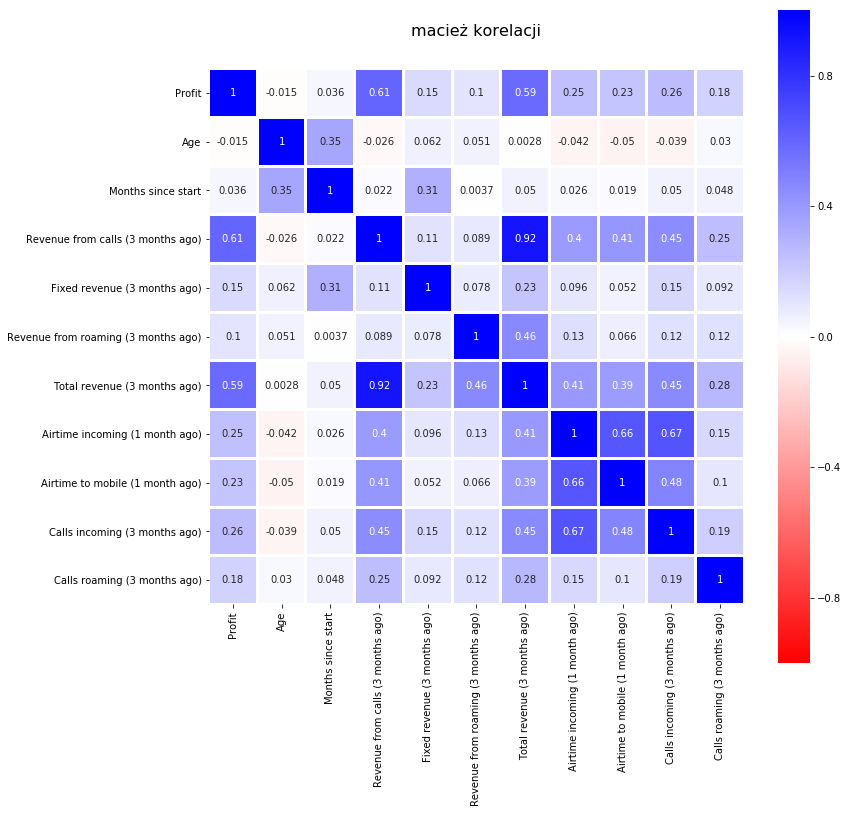

In [10]:
plt.figure(figsize=(12,12))
plt.title('macież korelacji', y=1.05, size=16)
sns.heatmap(data[col_numerical].astype(float).corr(), linewidths=2,  vmax=1.0, vmin = -1,
            square=True, cmap=colormap, annot=True)

In [11]:
def plot_cats(col_list, data):
    churn0 = data[data['Churn'] == 0]
    churn1 = data[data['Churn'] == 1]

    f, axes = plt.subplots(len(col_list), figsize=(10, 4*len(col_list))) 
    plt.subplots_adjust(hspace=0.3)
    
    i = 0
    for col in col_list:
        axes[i].set_title(col, size=16)
        sns.kdeplot(churn0[col], color=sns.xkcd_rgb["pale red"], label="0", ax = axes[i])
        sns.kdeplot(churn1[col], color=sns.xkcd_rgb["denim blue"], label="1", ax = axes[i])
        i += 1
    
#     sns.kdeplot(churn0['Profit'], label=0, ax = axes[0])
#     sns.kdeplot(churn1['Profit'], label=1 ,ax = axes[0])

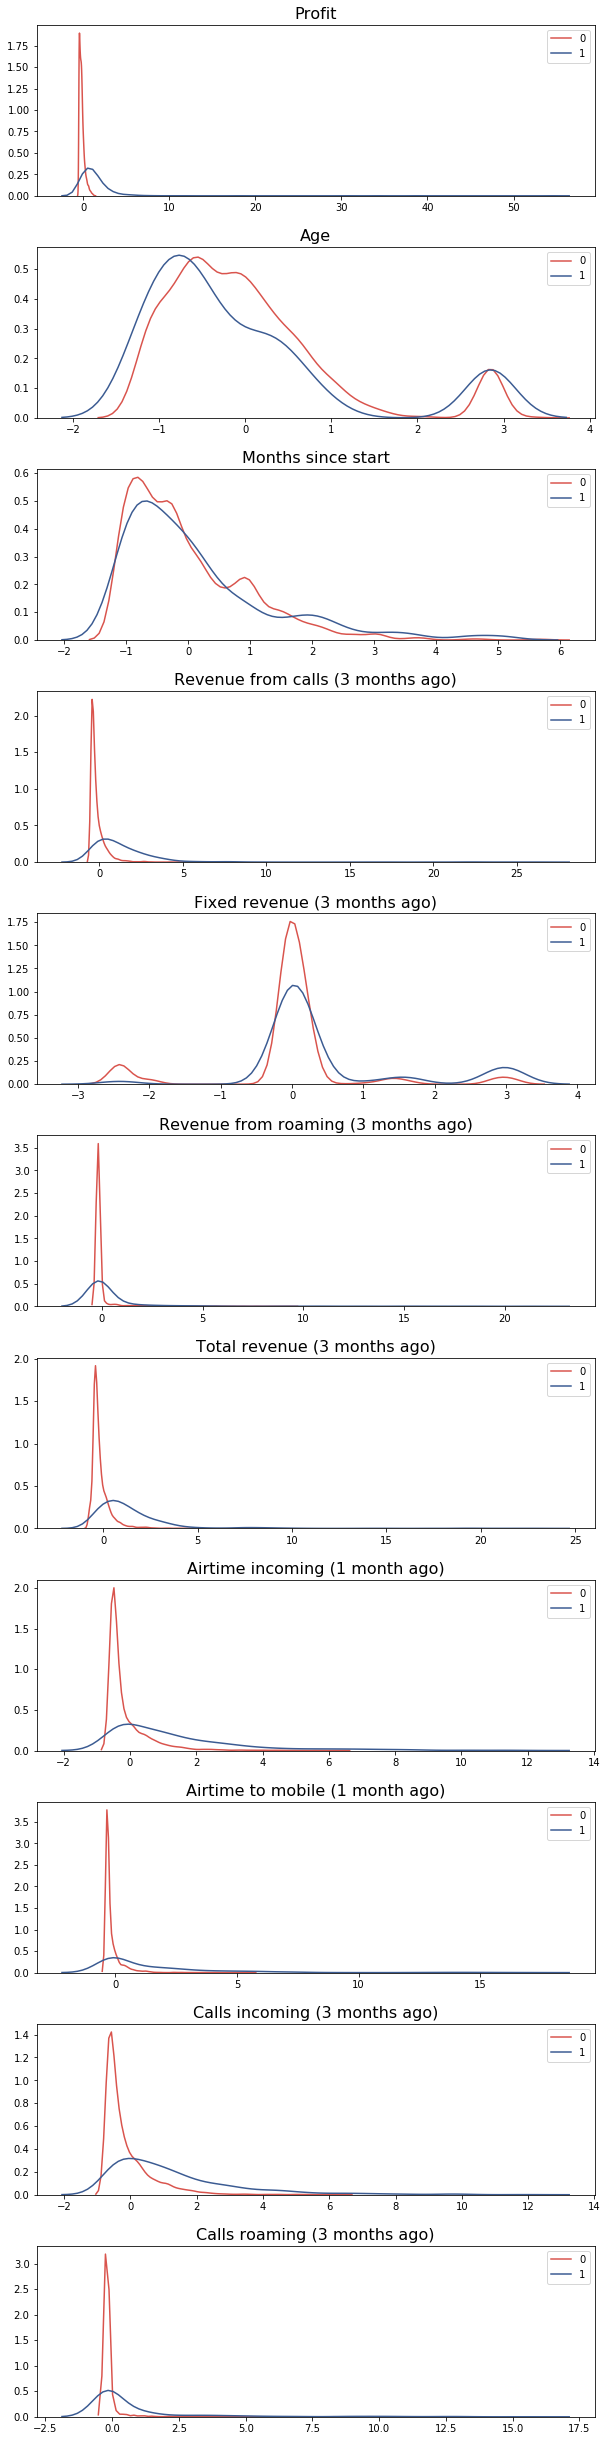

In [12]:
plot_cats(col_numerical, data)

### Podział na zbiór treningowy i testowy

In [13]:
X = data.drop('Churn', axis=1)
y = data.Churn

train_X, test_X, train_y, test_y = train_test_split(X, y, random_state = 0)

## Modele

In [47]:
def ROC(proba_list, names_list, test_X, test_y):
    for proba_y, name in zip(proba_list, names_list):
        fpr, tpr, _ = roc_curve(test_y, proba_y)
        auc = roc_auc_score(test_y, proba_y)
        plt.plot(fpr,tpr,label="{} , auc = {:.3f}".format(name, auc))
    plt.legend(loc=4)
    plt.plot([0, 1],[0, 1])

### Baseline model

In [15]:
data['Churn'].value_counts()

0    10629
1     1181
Name: Churn, dtype: int64

In [16]:
def baseline_model(X):
    return [0] * len(X)

In [17]:
a = 0
s = 0
for (a1, a2) in zip(baseline_model(data), data['Churn']) :
    s += 1
    if a1 == a2:
        a += 1
print("Baseline model accuracy: {}".format(a/s))

Baseline model accuracy: 0.9


### PK models

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense

/home/pkacz/nauka/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [19]:
train_X, test_X, train_y, test_y

(       Profit   Age  Cancelled  Months since start  Way of payment Region  \
 7317    -0.22  0.73          0               -0.72  Standing Order      4   
 8986    -0.35  0.12          0               -0.29  Standing Order      4   
 5306     0.00 -1.25          0               -0.61  Standing Order      3   
 4339     0.09  2.85          0                1.81  Standing Order      9   
 ...       ...   ...        ...                 ...             ...    ...   
 3264    -0.23 -0.94          0                0.76  Standing Order      0   
 9845    -0.39 -1.10          0               -0.82  Standing Order      5   
 10799    0.35 -0.94          0               -1.03  Standing Order      7   
 2732    -0.27 -1.10          0               -1.03  Standing Order      9   
 
       Profit segment   Sex  Tariff model  Academic title  \
 7317               D  Male             5               0   
 8986               D  Male             5               0   
 5306               D  Male        

In [20]:
train_X_PK = train_X[col_PK]
test_X_PK = test_X[col_PK]

train_X_PK = pd.get_dummies(train_X_PK)
test_X_PK = pd.get_dummies(test_X_PK)

In [21]:
train_X_PK

,Profit,Fixed revenue (3 months ago),Airtime to mobile (1 month ago),Cancelled,Way of payment_Standing Order,Way of payment_Unknown
7317,-0.22,0.17,-0.27,0,1,0
8986,-0.35,-0.05,-0.27,0,1,0
5306,0.00,0.17,0.57,0,1,0
4339,0.09,-0.05,-0.35,0,1,0
...,...,...,...,...,...,...
3264,-0.23,-0.05,-0.33,0,1,0
9845,-0.39,-0.05,-0.31,0,1,0
10799,0.35,-0.05,1.38,0,1,0
2732,-0.27,-0.05,-0.05,0,1,0


#### Decision Tree

In [22]:
PK_model1 = DecisionTreeClassifier()
PK_model1.fit(train_X_PK, train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [23]:
PK_model1.score(test_X_PK, test_y)

0.9204199119539451

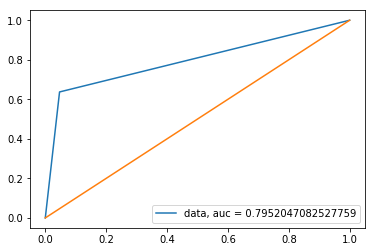

In [44]:
predicted_y_PK = PK_model1.predict_proba(test_X_PK)[:,1]
fpr, tpr, _ = roc_curve(test_y, predicted_y_PK)
auc = roc_auc_score(test_y, predicted_y_PK)
plt.plot(fpr,tpr,label="data, auc = {}".format(str(auc)))
plt.legend(loc=4)
plt.plot(tpr,tpr)

#### Random Forest

In [25]:
PK_model2 = RandomForestClassifier()
PK_model2.fit(train_X_PK, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [26]:
PK_model2.score(test_X_PK, test_y)

0.9434473416864206

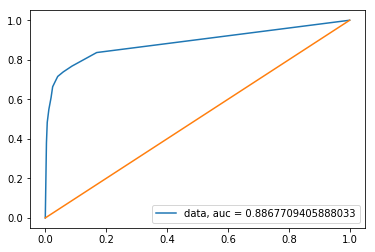

In [27]:
predicted_y_PK = PK_model2.predict_proba(test_X_PK)[:,1]
fpr, tpr, _ = roc_curve(test_y, predicted_y_PK)
auc = roc_auc_score(test_y, predicted_y_PK)
plt.plot(fpr,tpr,label="data, auc = {}".format(str(auc)))
plt.legend(loc=4)
plt.plot(tpr,tpr)

#### XGBoost

In [28]:
PK_model3 = XGBClassifier()
PK_model3.fit(train_X_PK, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [29]:
PK_model3.score(test_X_PK, test_y)

/home/pkacz/nauka/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9464950897392482

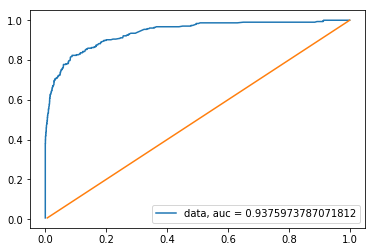

In [30]:
predicted_y_PK = PK_model3.predict_proba(test_X_PK)[:,1]
fpr, tpr, _ = roc_curve(test_y, predicted_y_PK)
auc = roc_auc_score(test_y, predicted_y_PK)
plt.plot(fpr,tpr,label="data, auc = {}".format(str(auc)))
plt.legend(loc=4)
plt.plot(tpr,tpr)

#### Neural Network

In [31]:
PK_model4 = Sequential()

PK_model4.add(Dense(units=128, activation='relu', input_dim=len(train_X_PK.T)))
PK_model4.add(Dense(units=32, activation='relu'))
PK_model4.add(Dense(units=1, activation='sigmoid'))

PK_model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
history = PK_model4.fit(train_X_PK, train_y, epochs=200, batch_size=128)

Epoch 1/200
8857/8857 [==============================] - 0s 29us/step - loss: 0.3374 - acc: 0.9128
Epoch 2/200
8857/8857 [==============================] - 0s 11us/step - loss: 0.1468 - acc: 0.9516
Epoch 3/200
8857/8857 [==============================] - 0s 11us/step - loss: 0.1436 - acc: 0.9539
Epoch 4/200
8857/8857 [==============================] - 0s 11us/step - loss: 0.1424 - acc: 0.9524
Epoch 5/200
8857/8857 [==============================] - 0s 12us/step - loss: 0.1414 - acc: 0.9528
Epoch 6/200
8857/8857 [==============================] - 0s 12us/step - loss: 0.1406 - acc: 0.9521
Epoch 7/200
8857/8857 [==============================] - 0s 11us/step - loss: 0.1407 - acc: 0.9521
Epoch 8/200
8857/8857 [==============================] - 0s 11us/step - loss: 0.1400 - acc: 0.9539
Epoch 9/200
8857/8857 [==============================] - 0s 12us/step - loss: 0.1400 - acc: 0.9528
Epoch 10/200
8857/8857 [==============================] - 0s 13us/step - loss: 0.1395 - acc: 0.9538
Epoch 11/

8857/8857 [==============================] - 0s 10us/step - loss: 0.1352 - acc: 0.9550
Epoch 84/200
8857/8857 [==============================] - 0s 12us/step - loss: 0.1350 - acc: 0.9556
Epoch 85/200
8857/8857 [==============================] - 0s 14us/step - loss: 0.1350 - acc: 0.9551
Epoch 86/200
8857/8857 [==============================] - 0s 13us/step - loss: 0.1348 - acc: 0.9550
Epoch 87/200
8857/8857 [==============================] - 0s 12us/step - loss: 0.1353 - acc: 0.9546
Epoch 88/200
8857/8857 [==============================] - 0s 12us/step - loss: 0.1344 - acc: 0.9561
Epoch 89/200
8857/8857 [==============================] - 0s 13us/step - loss: 0.1350 - acc: 0.9554
Epoch 90/200
8857/8857 [==============================] - 0s 12us/step - loss: 0.1347 - acc: 0.9551
Epoch 91/200
8857/8857 [==============================] - 0s 13us/step - loss: 0.1351 - acc: 0.9553
Epoch 92/200
8857/8857 [==============================] - 0s 12us/step - loss: 0.1356 - acc: 0.9547
Epoch 93/200


8857/8857 [==============================] - 0s 10us/step - loss: 0.1317 - acc: 0.9555
Epoch 165/200
8857/8857 [==============================] - 0s 12us/step - loss: 0.1332 - acc: 0.9547
Epoch 166/200
8857/8857 [==============================] - 0s 12us/step - loss: 0.1326 - acc: 0.9550
Epoch 167/200
8857/8857 [==============================] - 0s 12us/step - loss: 0.1314 - acc: 0.9560
Epoch 168/200
8857/8857 [==============================] - 0s 12us/step - loss: 0.1319 - acc: 0.9557
Epoch 169/200
8857/8857 [==============================] - 0s 13us/step - loss: 0.1322 - acc: 0.9560
Epoch 170/200
8857/8857 [==============================] - 0s 12us/step - loss: 0.1323 - acc: 0.9561
Epoch 171/200
8857/8857 [==============================] - 0s 13us/step - loss: 0.1319 - acc: 0.9562
Epoch 172/200
8857/8857 [==============================] - 0s 12us/step - loss: 0.1326 - acc: 0.9557
Epoch 173/200
8857/8857 [==============================] - 0s 12us/step - loss: 0.1317 - acc: 0.9561
Epoc

In [33]:
print(PK_model4.evaluate(test_X_PK, test_y))
PK_model4.metrics_names

2953/2953 [==============================] - 0s 30us/step
[0.16368643477492228, 0.943785980358957]


['loss', 'acc']

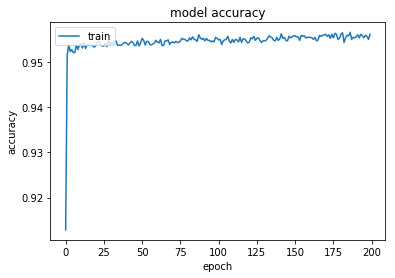

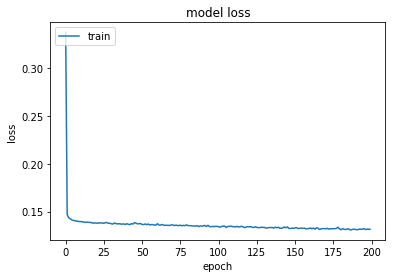

In [34]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Summary PK

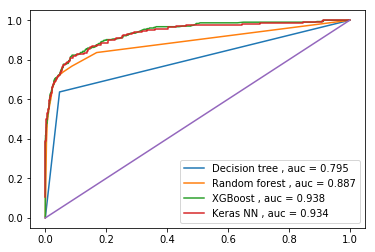

In [48]:
proba_list_PK = [
    PK_model1.predict_proba(test_X_PK)[:,1],
    PK_model2.predict_proba(test_X_PK)[:,1],
    PK_model3.predict_proba(test_X_PK)[:,1],
    PK_model4.predict_proba(test_X_PK)[:,0]
]
models_names_PK = ["Decision tree", "Random forest", "XGBoost", "Keras NN"]
ROC(proba_list_PK, models_names_PK, test_X_PK, test_y)